## For the paper, we want to give the following information about the text datasets
* num tokens
* num _unique_ tokens
* num _unique_ tokens that have GloVe representations (probably more meaningful)
* dates of data collection
* avg instances per building
* some unique words to this dataset?

### Imports

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

# we basically want to pretend to be in a different directory
import os
if 'notebooks' not in os.listdir():
    # want to go up one level
    os.chdir('..')

import itertools
import json
import pickle
from datetime import datetime
from collections import Counter, defaultdict

import matplotlib.pyplot as plt
import nltk
import numpy as np
import seaborn as sns
from dateutil.parser import parse 

import util.load_embeddings
from features.text_vector import TextEmbeddingBuilder
from util.enums import TextType, PretrainedEmbeddingType, BuildingTextEmbeddingType

In [2]:
INP_TWEET_FILE    = 'text_embeddings/input_data/processed_geotagged_tweets.txt'
INP_REDDIT_FILE   = 'text_embeddings/input_data/building_reddit_data_quality_control.pickle'
INP_CAMP_INF_FILE = 'text_embeddings/input_data/building_text.pickle'

In [3]:
with open('data/building_whitelists/location_twitter_reddit_mention_campus_info.whitelist', 'r') as f:
    location_whitelist = set(f.read().splitlines())
    
glove_embeddings = util.load_embeddings.load(PretrainedEmbeddingType.GLOVE_TWITTER).vectors

Loading embeddings...
Finished loading embeddings


## Twitter

In [4]:
# read data
twitter_location_data = defaultdict(list)
twitter_jsons = []
with open(INP_TWEET_FILE, 'r') as f:
    for line in f.read().splitlines():
        tweet_json = json.loads(line)
        loc = tweet_json['LEAP_location']
        if loc in location_whitelist:
            twitter_jsons.append(tweet_json)
            tokenized_tweet = nltk.word_tokenize(tweet_json.get('full_text', tweet_json.get('text')))
            twitter_location_data[loc].extend(tokenized_tweet)

num tokens: 655034
unique tokens: 72785
unique glove tokens: 18130
mean instances per building: 320.3863636363636
median instances per building 166.5


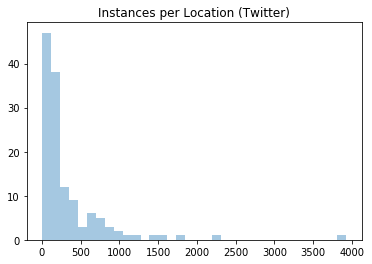

min timestamp: 2010-09-13 12:04:53
max timestamp: 2019-08-05 10:27:03


In [5]:
# num tokens
n_tokens = 0
for tokens in twitter_location_data.values():
    n_tokens += len(tokens)
print('num tokens:', n_tokens)

# unique tokens
unique_tokens = set()
for tokens in twitter_location_data.values():
    unique_tokens.update(tokens)
print('unique tokens:', len(unique_tokens))

# unique tokens included in GloVe
glove_unique_tokens = set()
for token in unique_tokens:
    if token in glove_embeddings:
        glove_unique_tokens.add(token)
print('unique glove tokens:', len(glove_unique_tokens))

# avg instances per building (1 instance = 1 tweet)
instances_per_building = Counter()
for tweet_json in twitter_jsons:
    instances_per_building[tweet_json['LEAP_location']] += 1
print('mean instances per building:', np.mean(list(instances_per_building.values())))
print('median instances per building', np.median(list(instances_per_building.values())))
sns.distplot(list(instances_per_building.values()), kde=False)
plt.title("Instances per Location (Twitter)")
plt.show()

def get_timestamp(tweet_json):
    if 'timestamp_ms' in tweet_json:
        return int(tweet_json['timestamp_ms']) // 1000
    else:
        return int(parse(tweet_json['created_at']).timestamp())

print('min timestamp:', datetime.fromtimestamp(min(get_timestamp(tweet_json) for tweet_json in twitter_jsons)))
print('max timestamp:', datetime.fromtimestamp(max(get_timestamp(tweet_json) for tweet_json in twitter_jsons)))

## Reddit

In [6]:
# read data
embedding_builder = TextEmbeddingBuilder(TextType.REDDIT_MENTION, PretrainedEmbeddingType.GLOVE_TWITTER,
                                        BuildingTextEmbeddingType.TFIDF_PRETRAINED, None)
reddit_data = {k: v for k, v in embedding_builder.data.items() if k in location_whitelist}

MENTION_BLACKLIST = ['building', 'hall', 'center', 'of', 'library', 'house', 'school', 'michigan', 'and', 
                     'research', 'university', 'north', 'residence', 'arbor', 'institute', 'student', 'complex', 
                     'campus', 'the', 'south', 'service', 'housing']

# copied/modified from features/text_vector.py
def _has_mention(tokenized_text, nicknames):
    for word in tokenized_text:
        # a blacklist is used to remove words that appear in too many nicknames
        # we also do not search using very short words
        if word in MENTION_BLACKLIST or len(word) < 2:
            continue
        for nickname in nicknames:
            nickname_words = nickname.split()
            for nickname_word in nickname_words:
                if word.lower() == nickname_word.lower():
                    return True
    return False


with open('text_embeddings/input_data/building_reddit_data_quality_control.pickle', 'rb') as f:
    raw_reddit_data = pickle.load(f)

building_instance_counts = Counter()
for building, nickname_map in raw_reddit_data.items():
    if building not in location_whitelist:
        continue
    seen_threads = set()
    for thread in itertools.chain(*nickname_map.values()):
        if thread['id'] in seen_threads:
            continue
        seen_threads.add(thread['id'])

        tokenized_body = nltk.word_tokenize(thread['body'])
        if _has_mention(tokenized_body, nickname_map.keys()):
            building_instance_counts[building] += 1
        # for now, we can ignore the comment level
        for comments in thread['comments'].values():
            for comment in comments:
                tokenized_comment = nltk.word_tokenize(comment)
                if _has_mention(tokenized_comment, nickname_map.keys()):
                    building_instance_counts[building] += 1

num tokens: 882476
uniquie tokens: 22387
unique glove tokens: 11261
mean instances per buliding: 62.128787878787875
median instances per building: 20.0


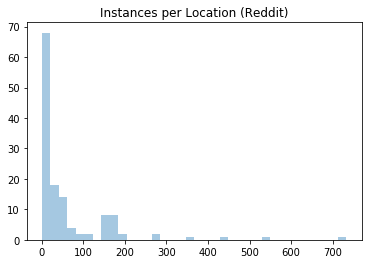

In [7]:
# num tokens
n_tokens = 0
for tokens in reddit_data.values():
    n_tokens += len(tokens)
print('num tokens:', n_tokens)

# unique tokens
unique_tokens = set()
for tokens in reddit_data.values():
    unique_tokens.update(tokens)
print('uniquie tokens:', len(unique_tokens))

# unique tokens included in GloVe
glove_unique_tokens = set()
for token in unique_tokens:
    if token in glove_embeddings:
        glove_unique_tokens.add(token)
print('unique glove tokens:', len(glove_unique_tokens))

# avg instances per building (1 instance = 1 comment or thread)
print('mean instances per buliding:', np.mean(list(building_instance_counts.values())))
print('median instances per building:', np.median(list(building_instance_counts.values())))
sns.distplot(list(building_instance_counts.values()), kde=False)
plt.title("Instances per Location (Reddit)")
plt.show()

## Campus Info

In [8]:
ci_embedding_builder = TextEmbeddingBuilder(TextType.CAMPUS_INFO, PretrainedEmbeddingType.GLOVE_TWITTER,
                                        BuildingTextEmbeddingType.TFIDF_PRETRAINED, None)
campus_info_data = {k: v for k, v in ci_embedding_builder.data.items() if k in location_whitelist}
with open('text_embeddings/input_data/building_text.pickle', 'rb') as f:
    campus_info_data_raw = pickle.load(f)

num tokens: 581062
uniquie tokens: 28675
unique glove tokens: 9390
mean instances per building: 6.212121212121212
median instances per building 3.5


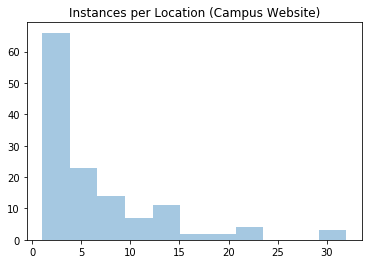

In [9]:
# num tokens
n_tokens = 0
for tokens in campus_info_data.values():
    n_tokens += len(tokens)
print('num tokens:', n_tokens)

# unique tokens
unique_tokens = set()
for tokens in campus_info_data.values():
    unique_tokens.update(tokens)
print('uniquie tokens:', len(unique_tokens))

# unique tokens included in GloVe
glove_unique_tokens = set()
for token in unique_tokens:
    if token in glove_embeddings:
        glove_unique_tokens.add(token)
print('unique glove tokens:', len(glove_unique_tokens))

# avg instances per building (1 instance = 1 web page)
instances_per_building = [len(v) for k, v in campus_info_data_raw.items() if k in location_whitelist]
print('mean instances per building:', np.mean(instances_per_building))
print('median instances per building', np.median(instances_per_building))
sns.distplot(instances_per_building, kde=False)
plt.title("Instances per Location (Campus Website)")
plt.show()